In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd

#### Import data

In [2]:
data1 = pd.read_csv('../Data/Ferritin Results Feb22 to Feb23.csv')

data2 = pd.read_csv('../Data/Ferritin Results Mar22 to Oct23.csv')

data3 = pd.read_csv('../Data/Ferritin Results Nov23 to Jun24.csv')

#### Organize data

In [3]:
# drop col not present in other datasets
data1 = data1.drop(columns="PRODUCT1")

In [4]:
# rename HEMACUE.RESULT1 to HB1
data2.rename(columns={'HAEMACUE.RESULT1': 'HB1'}, inplace=True)

In [5]:
# rename columns of data3 to match other df's 
data3.columns = ['_ID', 'ALPHA.KEY', 'COBAS.FERRITIN.RATIO1', 'RACE', 'GROUPRH', 'AGE', 'BLEEDPAN', 'DATE.BLED', 'NOD', 'SMS.TEMPLATE', 'FERRITIN.SMS.DATE', 'THERAP', 'HB1' ]

In [6]:
# rearrange columns so all df's have same schema
data2 = data2[['_ID', 'ALPHA.KEY', 'COBAS.FERRITIN.RATIO1', 'RACE', 'GROUPRH', 'BLEEDPAN', 'DATE.BLED', 'AGE', 'NOD', 'SMS.TEMPLATE', 'FERRITIN.SMS.DATE', 'HB1', 'THERAP']]
data3 = data3[['_ID', 'ALPHA.KEY', 'COBAS.FERRITIN.RATIO1', 'RACE', 'GROUPRH', 'BLEEDPAN', 'DATE.BLED', 'AGE', 'NOD', 'SMS.TEMPLATE', 'FERRITIN.SMS.DATE', 'HB1', 'THERAP']]

#### Join data

In [7]:
# create a new dataframe by joining existing dataframes
data_joined = pd.concat([data1, data2, data3], axis=0, ignore_index=True, verify_integrity=True)

In [8]:
# Create df containing therapeutic donors only
Therap_donors_only = data_joined[data_joined['THERAP'].notnull()]

# remove rows with values occuring in the THERAP column
data_joined_therap_dropped = data_joined[data_joined['THERAP'].isnull()]

#### Data Transformations

In [9]:
# Drop unnecessary cols from df
transformed_data = data_joined_therap_dropped.drop(columns=['SMS.TEMPLATE', 'FERRITIN.SMS.DATE', 'THERAP'], axis=1)

In [10]:
# rename columns
transformed_data.columns = ['sample_id', 'donor_code', 'ferritin_ratio','race', 'group_rh', 'clinic_code', 'date_bled', 'age', 'donations', 'hb']

In [11]:
# convert 'ferritin_ratio' to float datatype, non-numeric values coerced to NaN
transformed_data['ferritin_ratio'] = transformed_data['ferritin_ratio'].str.replace(',','.')
transformed_data['ferritin_ratio'] = pd.to_numeric(transformed_data['ferritin_ratio'], errors='coerce')

In [12]:
# convert 'date_bled' to datetime datatype
transformed_data['date_bled'] = pd.to_datetime(transformed_data['date_bled'], format='%d/%m/%y')


In [13]:
# drop duplicates 
transformed_data.drop_duplicates(subset=['sample_id'], keep ='first', inplace = True)

In [14]:
# output csv files

# data_joined.to_csv('Ferritin_raw_data_Feb22_to_Jun24.csv', index=False)
# Therap_donors_only.to_csv('Therap_donors_only_data_Feb22_to_Jun24.csv', index = False)
# transformed_data.to_csv("Ferritin_transformed_data_Feb22_to_Jun24.csv", index=False)

In [15]:
transformed_data.isnull().sum()

sample_id              0
donor_code            49
ferritin_ratio         1
race                  53
group_rh           11088
clinic_code            1
date_bled              1
age                11094
donations          11067
hb                145797
dtype: int64

#### Feature Engineering 

In [16]:
def to_cat(x):
    """function to convert ferritin ratio into defined categories"""
    if x <= 5.9:
        return 'very low'
    elif x > 6 and x <=15.9:
        return 'low'
    elif x >= 16 and x<=500:
        return 'normal'
    elif x >=501 and x <=1000:
        return 'high'
    else:
        return 'very high'

    
def to_gender(x):
    """function to convert race to gender"""
    if x % 2 == 0:
        return 'Female'
    else:
        return 'Male'

    
def to_color(x):
    """function to convert race to color"""
    if x <= 2:        
        return 'white'
    elif x > 2 and x <=4:
        return 'colored'
    elif x > 4 and x<=6:
        return 'other'
    else:
        return 'black'

    
def to_groups(x):
    """function to convert group_rh to group only"""
    word = x.split(' ')
    return word[0]



def to_rh(x):
    """function to convert group_rh to rh only"""
    word = x.split(' ')
    return word[1]
 

def check_string_split(df, col):
    """Checks if string can be split by .split() function (ie: has two words), if NoT then drops row from df, returns df"""
    drop_rows = []
    
    # convert group_rh col to same dtype
    df[col] = df[col].astype(str)
    
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Check if the group_rh string can be split into two strings
        if len(row[col].split()) != 2:
            # If not, add the row index to the list of rows to drop
            drop_rows.append(index)
    # Drop the rows from the dataframe
    return df.drop(drop_rows, inplace=True)

In [17]:
# make a copy of df
feature_data = transformed_data.copy()

check_string_split(feature_data, 'group_rh')

# apply feature creation functions
feature_data['ferritin_cat'] = feature_data['ferritin_ratio'].apply(to_cat)
feature_data['gender'] = feature_data['race'].apply(to_gender) 
feature_data['color'] = feature_data['race'].apply(to_color)

feature_data['group'] = feature_data['group_rh'].apply(to_groups)
feature_data['rh'] = feature_data['group_rh'].apply(to_rh)


# Drop the 'race' column from the dataframe
feature_data.drop(columns=['race', 'group_rh'], inplace=True)

# create col of donor code counts
feature_data['donor_code_count'] = feature_data.groupby('donor_code')['donor_code'].transform('count')

# output csv file
# feature_data.to_csv("ferritin feature data.csv", index=False)

In [18]:
# display(feature_data.head())
# feature_data.info()

#### Create Haemoglobin dataframe

In [19]:
hb_df = feature_data.copy()

# select only rows with hb values
hb_df = hb_df[hb_df['hb'].notnull()]


# drop rows with missing values
hb_df.dropna(inplace=True)

# output csv file
# hb_df.to_csv("ferritin hemoglobin data.csv", index=False)

In [20]:
# display(hb_df.head())
# hb_df.info()

### Clean Data

In [21]:
clean_data = feature_data.copy()

In [22]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310709 entries, 5 to 352003
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   sample_id         310709 non-null  int64         
 1   donor_code        310665 non-null  object        
 2   ferritin_ratio    310708 non-null  float64       
 3   clinic_code       310708 non-null  object        
 4   date_bled         310708 non-null  datetime64[ns]
 5   age               310634 non-null  float64       
 6   donations         310661 non-null  float64       
 7   hb                173863 non-null  float64       
 8   ferritin_cat      310709 non-null  object        
 9   gender            310709 non-null  object        
 10  color             310709 non-null  object        
 11  group             310709 non-null  object        
 12  rh                310709 non-null  object        
 13  donor_code_count  310665 non-null  float64       
dtypes: dateti

In [23]:
clean_data.describe()

,sample_id,ferritin_ratio,date_bled,age,donations,hb,donor_code_count
count,3.107090e+05,310708.000000,310708,310634.000000,310661.000000,1.738630e+05,310665.000000
mean,1.624864e+07,74.276871,2023-04-28 00:00:02.224596736,43.742636,32.339418,6.929379e+06,5.707824
min,1.137877e+07,1.160000,2022-02-21 00:00:00,-25.000000,-1.000000,0.000000e+00,1.000000
25%,1.206822e+07,23.000000,2022-09-12 00:00:00,31.000000,5.000000,1.380000e+01,2.000000
50%,1.217757e+07,43.700000,2023-05-24 00:00:00,45.000000,15.000000,1.460000e+01,5.000000
75%,1.227049e+07,85.400000,2023-12-08 00:00:00,56.000000,44.000000,1.560000e+01,8.000000
max,5.007302e+07,2000.000000,2024-06-28 00:00:00,100.000000,400.000000,1.204760e+12,53.000000
std,1.177010e+07,96.218617,NaN,15.460399,41.207898,2.889329e+09,4.855600


In [24]:
clean_data.isnull().sum()

sample_id                0
donor_code              44
ferritin_ratio           1
clinic_code              1
date_bled                1
age                     75
donations               48
hb                  136846
ferritin_cat             0
gender                   0
color                    0
group                    0
rh                       0
donor_code_count        44
dtype: int64

In [25]:
# Drop rows where any 'age' value is greater than 100
clean_data = clean_data[clean_data['age'] < 100]

In [26]:
# Change incorrect negative values to positive
clean_data['age'] = clean_data['age'].abs()
clean_data['donations'] = clean_data['donations'].abs()

In [27]:
# Fill in missing value in 'clinic_code' column
index_to_replace = clean_data[clean_data['clinic_code'].isna()].index[0]
column_to_replace = 'clinic_code'

clean_data.loc[index_to_replace, column_to_replace] = 'CG4' # from BMS


In [28]:
# NOTE: 
# 1. SAFE TO DROP DONOR CODES AS THEY ARE NST's (TST) 
# 2. NEED TO DROP CLINIC CODES ['AFN', 'TTD', 'TST'] AS THEY ARE NOT ARBC DONORS, THERAPEUTIC DONORS ALREADY DROPPED AND BALANCE OF MED DONORS ARE DESIGNATED DONORS

# Drop the rows
clinic_codes = ['AFN', 'TTD', 'TST']
clean_data = clean_data[~clean_data['clinic_code'].isin(clinic_codes)]

In [29]:
# Fill in missing values in 'age' column
missing_age = [55, 55, 55, 50, 55, 50, 55, 55, 56, 56, 51, 56, 56, 56, 56, 56, 56, 56, 56, 56, 51, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57] # from BMS
column_to_fill = 'age'  

# Create an iterator for the fill values
fill_iter = iter(missing_age)

# Function to fill missing values with values from the list
def fill_missing_with_list(row):
    if pd.isna(row[column_to_fill]):
        return next(fill_iter)
    return row[column_to_fill]

# Apply the function to the column
clean_data[column_to_fill] = clean_data.apply(fill_missing_with_list, axis=1)

In [30]:
# Fill in missing values in 'donations' column
missing_donations = [2, 6, 1, 4] # from BMS
column_to_fill = 'donations' 

# Create an iterator for the fill values
fill_iter = iter(missing_donations)

# Function to fill missing values with values from the list
def fill_missing_with_list(row):
    if pd.isna(row[column_to_fill]):
        return next(fill_iter)
    return row[column_to_fill]

# Apply the function to the column
clean_data[column_to_fill] = clean_data.apply(fill_missing_with_list, axis=1)

In [31]:
# drop missing value as it is not on BMS
clean_data = clean_data.dropna(subset=['ferritin_ratio'])

In [32]:
# drop 'hb' column if not needed
clean_data = clean_data.drop('hb', axis=1)

#### EDA

In [33]:
data = clean_data.copy()

In [34]:
data.describe()

,sample_id,ferritin_ratio,date_bled,age,donations,donor_code_count
count,3.070490e+05,307049.000000,307049,307049.000000,307049.000000,307049.000000
mean,1.628280e+07,74.244893,2023-04-28 11:45:57.664086016,43.621774,31.433540,5.644812
min,1.137877e+07,1.160000,2022-02-21 00:00:00,11.000000,0.000000,1.000000
25%,1.207023e+07,23.000000,2022-09-12 00:00:00,31.000000,5.000000,2.000000
50%,1.217823e+07,43.600000,2023-05-25 00:00:00,45.000000,15.000000,5.000000
75%,1.227068e+07,85.300000,2023-12-07 00:00:00,56.000000,43.000000,8.000000
max,5.007302e+07,2000.000000,2024-06-28 00:00:00,89.000000,400.000000,53.000000
std,1.181132e+07,96.350653,NaN,15.442557,39.729372,4.808596


In [35]:
sns.set_style('whitegrid')

In [36]:
# Calculate the mean value for each category
mean_values = data.groupby('ferritin_cat')['ferritin_ratio'].count().reset_index()
mean_values

,ferritin_cat,ferritin_ratio
0,high,2551
1,low,40402
2,normal,262112
3,very high,353
4,very low,1631


C:\Users\p02251\AppData\Local\Temp\ipykernel_18904\1309137100.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='ferritin_cat', data=data, order=['very low','low', 'normal', 'high', 'very high'], palette="Reds")


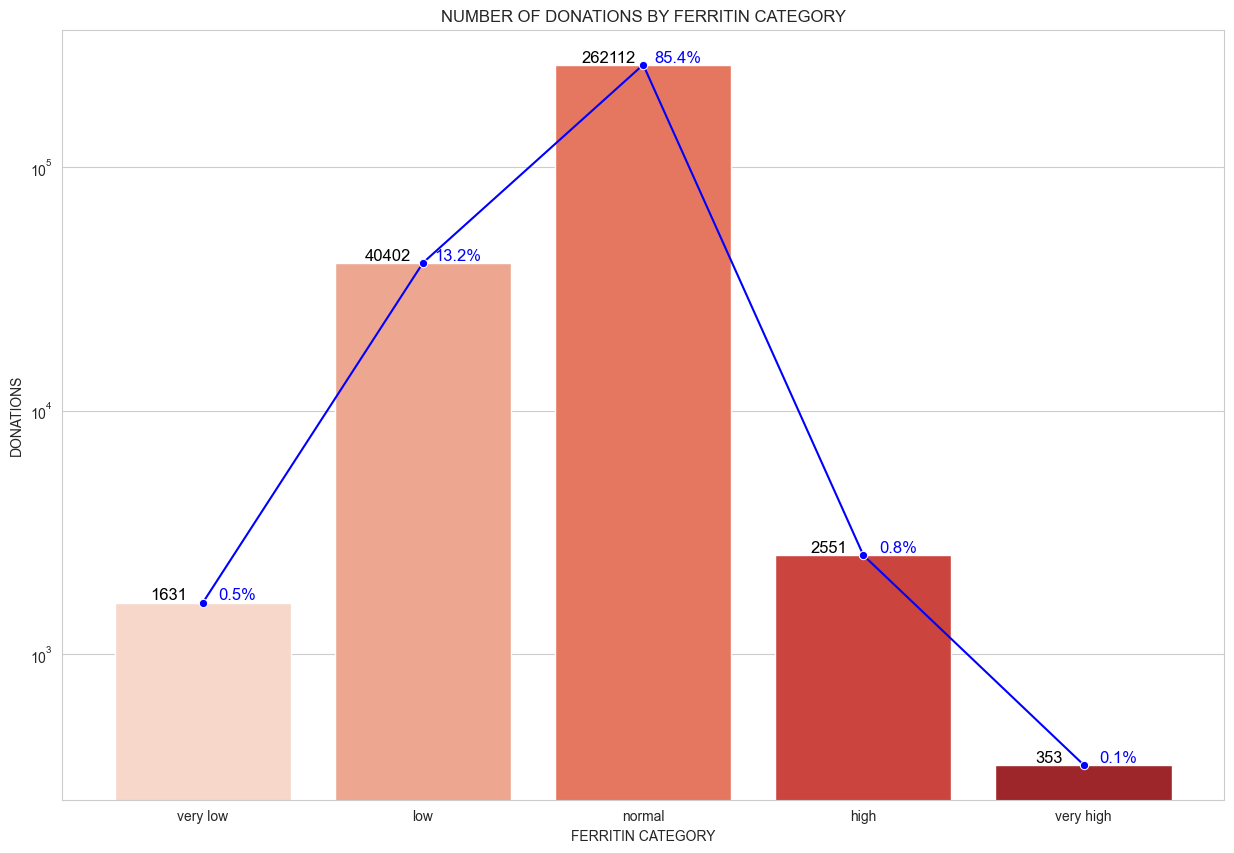

In [50]:
plt.figure(figsize=(15, 10))
ax = sns.countplot(x='ferritin_cat', data=data, order=['very low','low', 'normal', 'high', 'very high'], palette="Reds")

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Calculate the mean value for each category
mean_values = data.groupby('ferritin_cat')['ferritin_ratio'].count().reset_index()
# Plot the line plot on the same axes
sns.lineplot(x='ferritin_cat', y='ferritin_ratio', data=mean_values, ax=ax, color='b', marker='o')

total = len(data)

# Add values on top of the bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(count, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(-25, 2), 
                textcoords='offset points')
    
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='b', xytext=(25, 2), 
                textcoords='offset points')


plt.title('NUMBER OF DONATIONS BY FERRITIN CATEGORY')
plt.xlabel('FERRITIN CATEGORY')
plt.ylabel('DONATIONS')
plt.show()

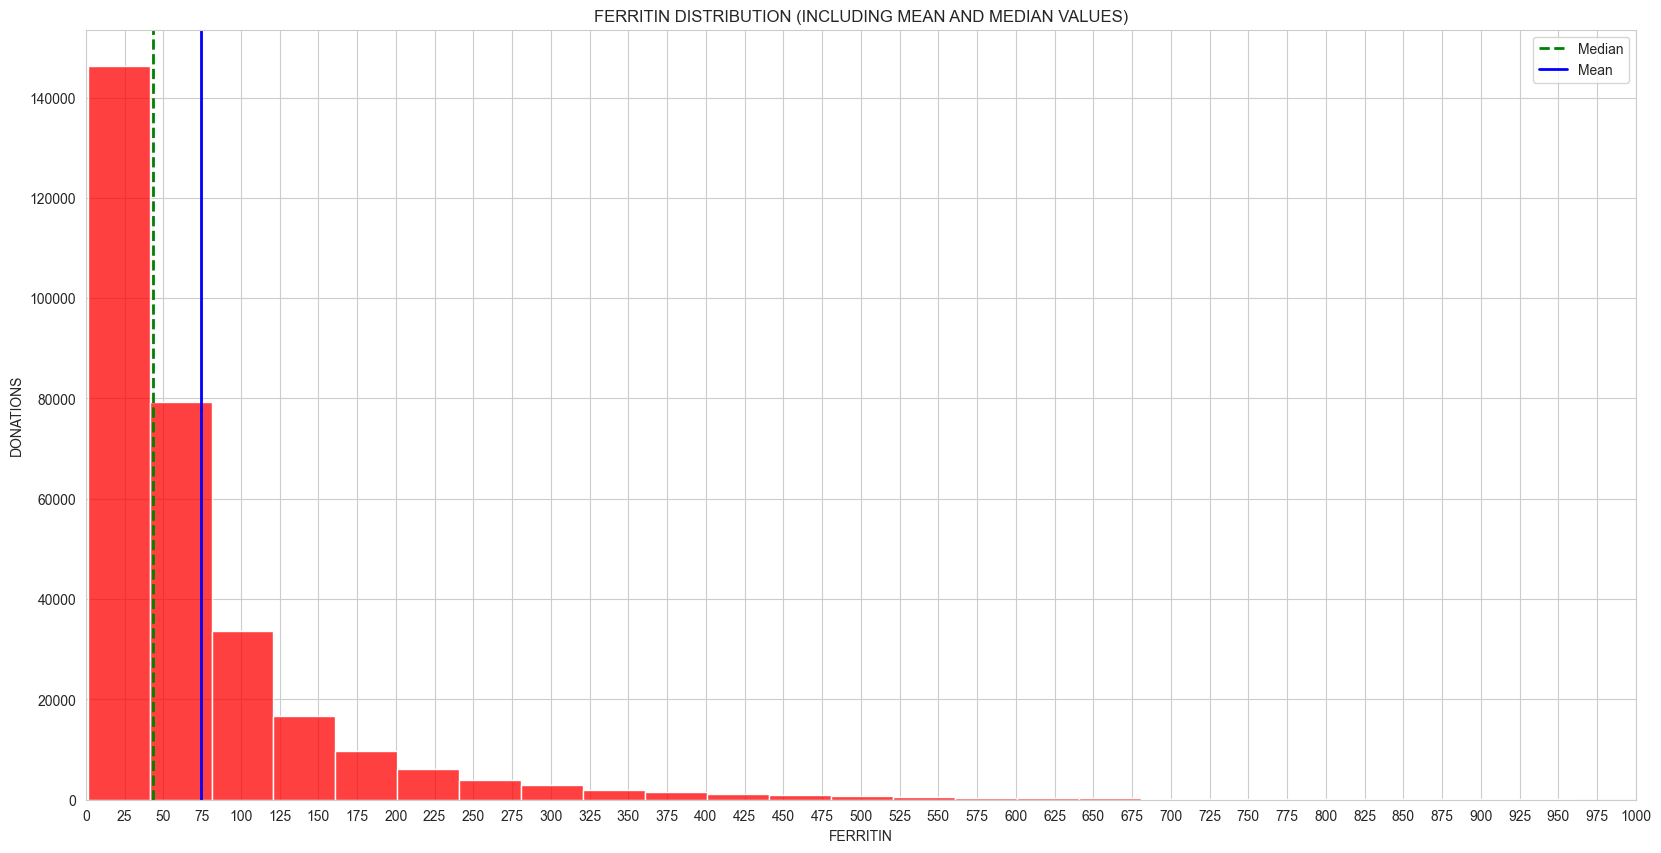

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(x='ferritin_ratio', data=data,bins=50, ax=ax,  color="r")

ax.axvline(x=data['ferritin_ratio'].median(), color='g', label='Median', linestyle='--', linewidth=2)
ax.axvline(x=data['ferritin_ratio'].mean(), color='b', label='Mean', linestyle='-', linewidth=2)
ax.set(xticks=(range(0,2100, 25)), xlim =(0,1000))

# Adding titles and labels
plt.title('FERRITIN DISTRIBUTION (INCLUDING MEAN AND MEDIAN VALUES)')
plt.xlabel('FERRITIN')
plt.ylabel('DONATIONS')

ax.legend()
plt.show()

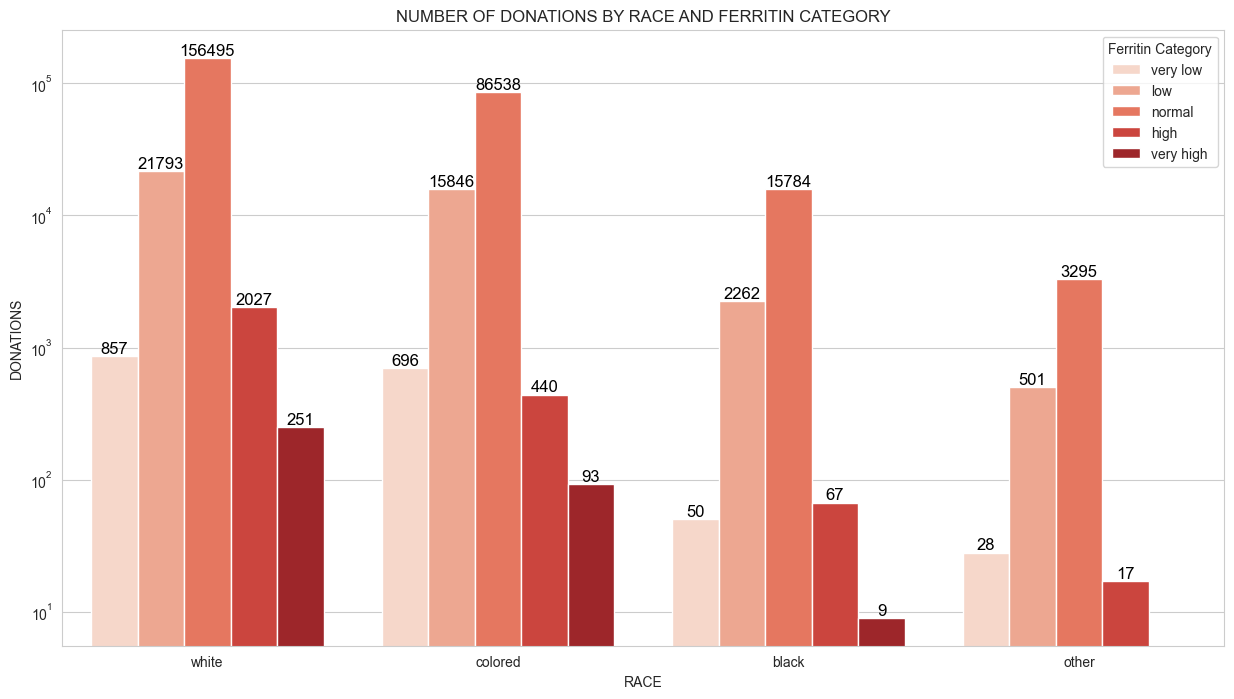

In [39]:
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='color', hue='ferritin_cat', data=data, order=['white', 'colored', 'black', 'other'],hue_order=['very low','low', 'normal', 'high', 'very high'], palette='Reds')

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Add values on top of the bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(count, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 2), 
                textcoords='offset points')

# Adding titles and labels
plt.title('NUMBER OF DONATIONS BY RACE AND FERRITIN CATEGORY')
plt.legend(title='Ferritin Category')
plt.xlabel('RACE')
plt.ylabel('DONATIONS')

plt.show()

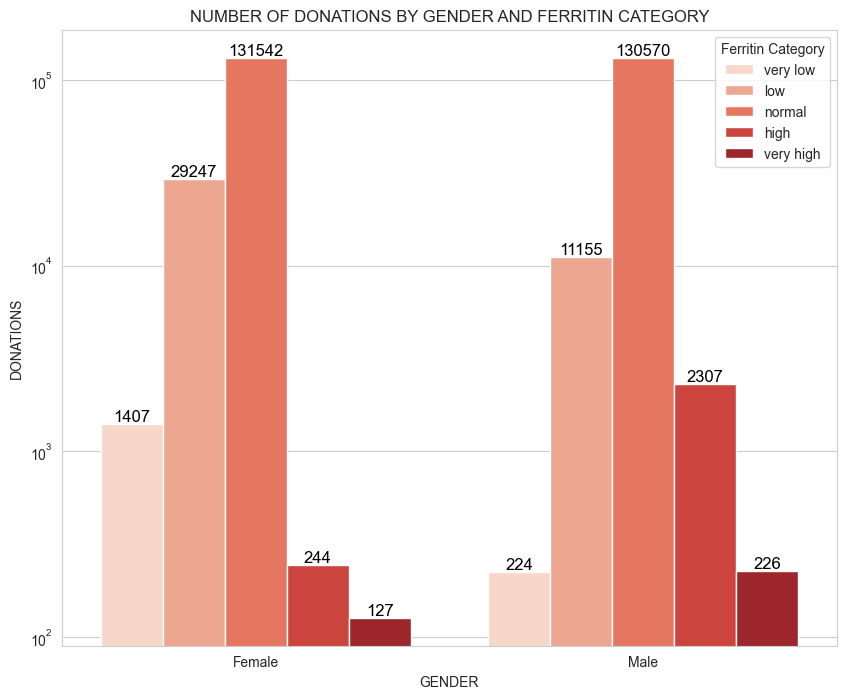

In [40]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(x='gender', hue='ferritin_cat', data=data, hue_order=['very low','low', 'normal', 'high', 'very high'], palette="Reds")

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Add values on top of the bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(count, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 2), 
                textcoords='offset points')

# Adding titles and labels
plt.title('NUMBER OF DONATIONS BY GENDER AND FERRITIN CATEGORY')
plt.legend(title='Ferritin Category')
plt.xlabel('GENDER')
plt.ylabel('DONATIONS')

plt.show()

C:\Users\p02251\AppData\Local\Temp\ipykernel_18904\2748330813.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='ferritin_cat', y='age', data=data, order=['very low','low', 'normal', 'high', 'very high'], palette="Reds")


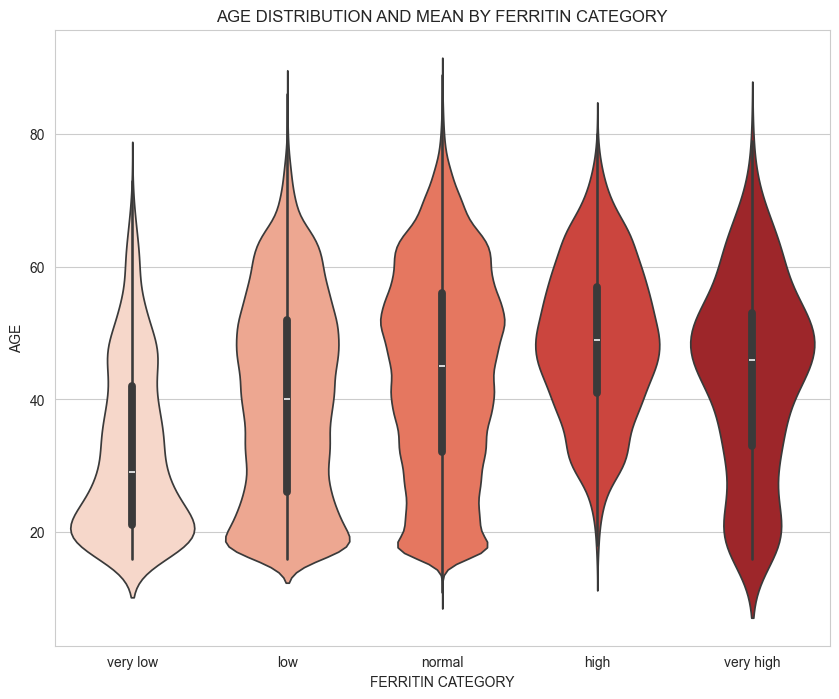

In [41]:
plt.figure(figsize=(10, 8))
# Violin plot
sns.violinplot(x='ferritin_cat', y='age', data=data, order=['very low','low', 'normal', 'high', 'very high'], palette="Reds")


# Adding titles and labels
plt.title('AGE DISTRIBUTION AND MEAN BY FERRITIN CATEGORY')
plt.xlabel('FERRITIN CATEGORY')
plt.ylabel('AGE')
plt.show()

In [42]:
grouped_df = data.groupby('ferritin_cat')['age'].agg(['mean', 'min', 'max'])
grouped_df

,mean,min,max
ferritin_cat,,,
high,48.859271,16.0,80.0
low,40.023439,16.0,86.0
normal,44.195977,11.0,89.0
very high,43.563739,16.0,79.0
very low,32.299816,16.0,73.0


In [43]:
filtered_df = data[(data['ferritin_cat'] == 'very low')]
filtered_df

,sample_id,donor_code,ferritin_ratio,clinic_code,date_bled,age,donations,ferritin_cat,gender,color,group,rh,donor_code_count
412,11718613,SYLVEV00020,4.22,EAI,2023-01-11,21.0,1.0,very low,Female,colored,A,POS,1.0
530,11718764,MARER000040,4.80,EBJ,2022-09-19,28.0,1.0,very low,Female,white,A,NEG,1.0
742,11897494,RASIET00010,5.74,ZGO,2022-03-09,23.0,8.0,very low,Female,colored,O,POS,2.0
791,11922339,SALMOM00010,5.80,ETM,2022-03-18,22.0,4.0,very low,Female,colored,A,POS,1.0
2794,11942490,NYATHN00010,5.81,EAR,2022-03-10,47.0,46.0,very low,Male,white,O,POS,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
351072,50069961,VOSM0000240,5.73,HDC,2024-04-24,17.0,1.0,very low,Female,white,O,POS,1.0
351097,50069992,CHINHT00020,5.01,ATC,2024-04-16,17.0,1.0,very low,Female,black,B,POS,1.0
351370,50070370,CLOETI00200,5.85,AUS,2024-04-22,16.0,1.0,very low,Female,colored,AB,POS,1.0
351463,50071001,VNSCHK00240,5.74,HJK,2024-06-19,21.0,1.0,very low,Female,white,O,POS,1.0


In [44]:
# create col of donor code counts
filtered_df['donor_code_count_2'] = filtered_df.groupby('donor_code')['donor_code'].transform('count')
low_fe_donors = filtered_df[(filtered_df['donor_code_count_2'] >= 6)]
low_fe_donors['donor_code'].unique()

C:\Users\p02251\AppData\Local\Temp\ipykernel_18904\1349935776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['donor_code_count_2'] = filtered_df.groupby('donor_code')['donor_code'].transform('count')


array(['PETERNG0010', 'COMBRS00080', 'FAKIRI00010', 'ROHLAN00010',
       'MITHAS00010'], dtype=object)

In [45]:
vl_donor1 = low_fe_donors[low_fe_donors["donor_code"]== 'MITHAS00010'].sort_values(by='date_bled')
# vl_donor.sort_values(by='date_bled')
vl_donor1

,sample_id,donor_code,ferritin_ratio,clinic_code,date_bled,age,donations,ferritin_cat,gender,color,group,rh,donor_code_count,donor_code_count_2
108159,12097765,MITHAS00010,4.92,KPC,2022-11-18,47.0,34.0,very low,Male,other,A,POS,11.0,6
165601,12170394,MITHAS00010,4.68,KC2,2023-05-23,48.0,36.0,very low,Male,other,A,POS,11.0,6
203830,12200703,MITHAS00010,5.52,KC3,2023-08-23,48.0,36.0,very low,Male,other,A,POS,11.0,6
174547,12218682,MITHAS00010,4.86,KC5,2023-10-20,48.0,36.0,very low,Male,other,A,POS,11.0,6
281106,12254089,MITHAS00010,4.98,KC1,2023-12-18,49.0,40.0,very low,Male,other,A,POS,11.0,6
308035,12285535,MITHAS00010,4.44,KC3,2024-03-27,49.0,40.0,very low,Male,other,A,POS,11.0,6


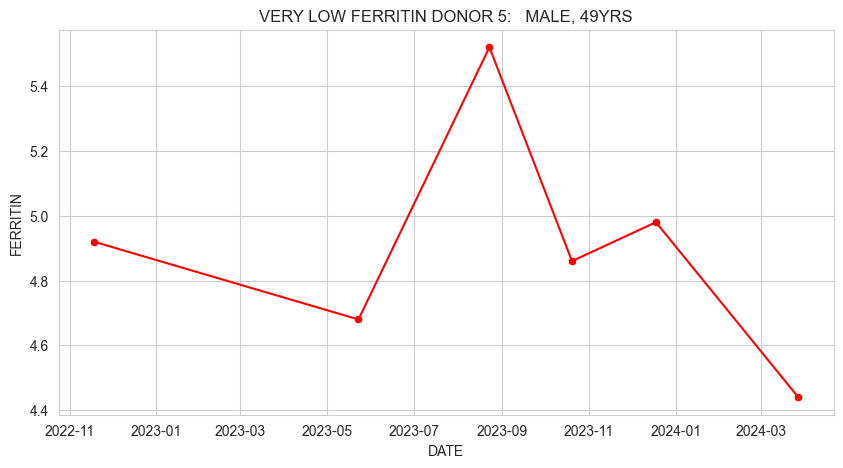

In [46]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='date_bled', y='ferritin_ratio', data=vl_donor1, color='r')
sns.scatterplot(x='date_bled', y='ferritin_ratio', data=vl_donor1, color='r')

# Adding titles and labels
plt.title('VERY LOW FERRITIN DONOR 5:   MALE, 49YRS')
plt.xlabel('DATE')
plt.ylabel('FERRITIN')
plt.show()

In [47]:
vl_donor2 = low_fe_donors[low_fe_donors["donor_code"]== 'MITHAS00010'].sort_values(by='date_bled')
# vl_donor.sort_values(by='date_bled')
vl_donor2

,sample_id,donor_code,ferritin_ratio,clinic_code,date_bled,age,donations,ferritin_cat,gender,color,group,rh,donor_code_count,donor_code_count_2
108159,12097765,MITHAS00010,4.92,KPC,2022-11-18,47.0,34.0,very low,Male,other,A,POS,11.0,6
165601,12170394,MITHAS00010,4.68,KC2,2023-05-23,48.0,36.0,very low,Male,other,A,POS,11.0,6
203830,12200703,MITHAS00010,5.52,KC3,2023-08-23,48.0,36.0,very low,Male,other,A,POS,11.0,6
174547,12218682,MITHAS00010,4.86,KC5,2023-10-20,48.0,36.0,very low,Male,other,A,POS,11.0,6
281106,12254089,MITHAS00010,4.98,KC1,2023-12-18,49.0,40.0,very low,Male,other,A,POS,11.0,6
308035,12285535,MITHAS00010,4.44,KC3,2024-03-27,49.0,40.0,very low,Male,other,A,POS,11.0,6


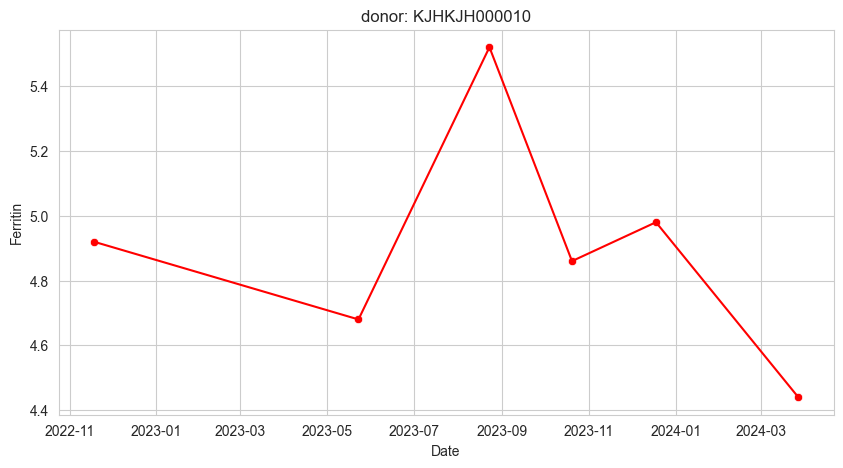

In [48]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='date_bled', y='ferritin_ratio', data=vl_donor2, color='r')
sns.scatterplot(x='date_bled', y='ferritin_ratio', data=vl_donor2, color='r')

# Adding titles and labels
plt.title('donor: KJHKJH000010')
plt.xlabel('Date')
plt.ylabel('Ferritin')

plt.show()

In [49]:
data.describe(include='all')

,sample_id,donor_code,ferritin_ratio,clinic_code,date_bled,age,donations,ferritin_cat,gender,color,group,rh,donor_code_count
count,3.070490e+05,307049,307049.000000,307049,307049,307049.000000,307049.000000,307049,307049,307049,307049,307049,307049.000000
unique,NaN,103409,NaN,660,NaN,NaN,NaN,5,2,4,10,3,NaN
top,NaN,JOSEPNA0010,NaN,NC6,NaN,NaN,NaN,normal,Female,white,O,POS,NaN
freq,NaN,53,NaN,6400,NaN,NaN,NaN,262112,162567,181423,143155,271911,NaN
mean,1.628280e+07,NaN,74.244893,NaN,2023-04-28 11:45:57.664086016,43.621774,31.433540,NaN,NaN,NaN,NaN,NaN,5.644812
min,1.137877e+07,NaN,1.160000,NaN,2022-02-21 00:00:00,11.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,1.207023e+07,NaN,23.000000,NaN,2022-09-12 00:00:00,31.000000,5.000000,NaN,NaN,NaN,NaN,NaN,2.000000
50%,1.217823e+07,NaN,43.600000,NaN,2023-05-25 00:00:00,45.000000,15.000000,NaN,NaN,NaN,NaN,NaN,5.000000
75%,1.227068e+07,NaN,85.300000,NaN,2023-12-07 00:00:00,56.000000,43.000000,NaN,NaN,NaN,NaN,NaN,8.000000
max,5.007302e+07,NaN,2000.000000,NaN,2024-06-28 00:00:00,89.000000,400.000000,NaN,NaN,NaN,NaN,NaN,53.000000
